In [11]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.integrate as scint
import scipy.special as sc
import math

## Bernoulli Model Bounds for pk = t

Plotting the bounds written down in the proof document: 

\begin{align*}
\text{Pr}(P_k\ne0) \geq 1-\exp( \frac{-n p_0 h_k}{\alpha}),
\end{align*}

\begin{align*}
\text{Pr}(P_k\ne n) \geq 1-\exp(-n(1-p_0) h_{k+1}),
\end{align*}

\begin{align*}
\text{Pr}(P_k \ne \{0, n\}) \geq 1 - (\exp(-n(1-p_0) h_{k+1}) + \exp(-n p_0 h_{k+1})),
\end{align*}

In [12]:
factors = np.zeros((10, 10))
factors[:, 0] = 1
for i in range(1, 10):
    for j in range(1, 10):
        factors[i, j] = factors[i - 1, j] * (j+1) + factors[i-1, j-1]

print(factors.astype(int))

[[    1     0     0     0     0     0     0     0     0     0]
 [    1     1     0     0     0     0     0     0     0     0]
 [    1     3     1     0     0     0     0     0     0     0]
 [    1     7     6     1     0     0     0     0     0     0]
 [    1    15    25    10     1     0     0     0     0     0]
 [    1    31    90    65    15     1     0     0     0     0]
 [    1    63   301   350   140    21     1     0     0     0]
 [    1   127   966  1701  1050   266    28     1     0     0]
 [    1   255  3025  7770  6951  2646   462    36     1     0]
 [    1   511  9330 34105 42525 22827  5880   750    45     1]]


In [13]:
import numpy as np
from scipy.special import comb
from itertools import product

def approx_bound(n, k, t, m, delta, n0, rollout_idx = 2):
    # Compute base probability p0
    p0 = (n0 + delta) / (n + m * delta)
    print(f'p0 {p0}')
    q0 = 1 - p0
    nct = comb(n, t, exact=True)

    # Precompute binomial coefficient
    binomials = np.array([comb(n, ai, exact=True) for ai in range(n+1)])

    fok = []
    def f(x):
        return (1-t/n)*(1 - np.exp(-x))
    fok.append(1-t/n)
    for i in range(1,rollout_idx - 1):
        fok.append(f(fok[-1]))
    
    # Compute the sum efficiently
    total_sum = 0.0

    if k == 1:
        return nct * p0 ** t * q0 ** (n - t)
    
    elif k == 2:
        for i in range(n+1):
            p1 = (i + delta) / (n + m * delta)
            q1 = 1 - p1
            total_sum += binomials[i] * p0 ** i * q0 ** (n - i) * nct * p1 ** t * q1 ** (n - t)
        return total_sum
    
    # Iterate over all valid (a1, a2, ..., a{k-1})
    for a in product(range(n+1), repeat=k-rollout_idx):

        # Compute pk values
        p = np.array([p0] + [(ai + delta) / (n + m * delta) for ai in a])
        q = 1 - p
        
        # Compute the binomial product term
        binomial_product = np.prod([binomials[a[i]] for i in range(k-rollout_idx)]) * nct
        
        # Compute the exponentiated fraction term
        fraction_product = np.prod([(p[i]) ** a[i] for i in range(k-rollout_idx)])
        
        # Compute the final probability term
        probability_product = np.prod([(q[i])** (n - a[i]) for i in range(k-rollout_idx)]) 
        
        total_sum += binomial_product * fraction_product * probability_product * np.exp(-(sum(fok))) * p[-1] * (1-p[-1]*(1-np.exp(-fok[-1])))**(n-t) #np.exp(-a[-1] * (1-np.exp(-(1-t/n))) * (1-t/n))
    
    return total_sum

In [14]:
import numpy as np
from scipy.special import comb
from itertools import product

def compute_weighted_sum(n, k, t, m, delta, n0):
    # Compute base probability p0
    p0 = (n0 + delta) / (n + m * delta)
    print(f'p0 {p0}')
    q0 = 1 - p0
    nct = comb(n, t, exact=True)
    
    # Precompute binomial coefficients
    binomials = np.array([comb(n, ai, exact=True) for ai in range(n+1)])
    
    # Compute the sum efficiently
    total_sum = 0.0

    if k == 1:
        return nct * p0 ** t * q0 ** (n - t)
    
    # Iterate over all valid (a1, a2, ..., a{k-1})
    for a in product(range(n+1), repeat=k-1):
        
        # Compute pk values
        p = np.array([p0] + [(ai + delta) / (n + m * delta) for ai in a])
        q = 1 - p
        
        # Compute the binomial product term
        binomial_product = np.prod([binomials[a[i]] for i in range(k-1)]) * nct
        
        # Compute the exponentiated fraction term
        fraction_product = np.prod([(p[i]) ** a[i] for i in range(k-1)]) * (p[-1]) ** t
        
        # Compute the final probability term
        probability_product = np.prod([(q[i])** (n - a[i]) for i in range(k-1)]) *(q[-1])**(n-t)
        
        total_sum += binomial_product * fraction_product * probability_product
    
    return total_sum


In [15]:
def approx_bound_fn_rollout_control(n, m, delta, n0, ng, t, rollout_idx):
    approx_bounds = []
    for k in range(rollout_idx + 1, ng+1):
        prob = approx_bound(n, k, t, m, delta, n0, rollout_idx)
        print(f"Computed for t={t}, k={k}: Prob = {prob}")
        approx_bounds.append(prob)
    
    approx_bound_wo_nct_list = np.array(approx_bounds)/comb(n, t, exact=True)

    return approx_bounds, approx_bound_wo_nct_list

In [16]:
def approx_bound_fn(n, m, delta, n0, ng, t_max):
    approx_bounds = []
    for t in range(t_max+1):
        t_probs = []
        for k in range(1, ng+1):
            prob = approx_bound(n, k, t, m, delta, n0)
            print(f"Computed for t={t}, k={k}: Prob = {prob}")
            t_probs.append(prob)
        approx_bounds.append(t_probs)
    
    approx_bound_wo_nct_list = []
    approx_bounds_np = np.array(approx_bounds)
    for i in range(len(approx_bounds)):
        approx_bound_wo_nct_list.append(approx_bounds_np[i]/comb(n, i, exact=True))

    return approx_bounds, approx_bound_wo_nct_list

In [17]:
def true_bound_fn(n, m, delta, n0, ng, t_max):
    true_probs = []
    for t in range(t_max+1):
        t_probs = []
        for k in range(1, ng+1):
            prob = compute_weighted_sum(n, k, t, m, delta, n0)
            print(f"Computed for t={t}, k={k}: Prob = {prob}")
            t_probs.append(prob)
        true_probs.append(t_probs)
    
    true_probs_wo_nct = []
    true_probs_np = np.array(true_probs)
    for i in range(len(true_probs_np)):
        true_probs_wo_nct.append(true_probs_np[i]/comb(10, i, exact=True))

    return true_probs, true_probs_wo_nct

In [18]:
def get_equidistant_points(data, num_points):
    '''
    Used to sample points from data for plotting purposes

    data: array of data points
    num_points: number of points to return
    '''
    data = np.asarray(data)
    if num_points > len(data):
        raise ValueError("num_points must not exceed the number of elements in data.")

    indices = np.linspace(0, len(data) - 1, num=num_points, dtype=int)

    return data[indices]


def plot_bernoulli_bounds(n_0, n, num_generations, m, delta, collapse_t = 0, with_nct = True):
    '''
    Given an initial probability p_0, this function plots the simulations, provided upper and lower bounds of the probability of not collapsing to zero for the Bernoulli model.


    p_0: initial probability of success
    n: number of samples per generation
    ng: number of generations to simulate
    collapse_indicator: array of probabilities to collapse to

    returns:
    collapse_array: simulated array of probabilities
    our_lower: array of our lower bounds
    our_upper: array of our upper bounds
    seddik_lower: array of Seddick et al. lower bounds
    seddik_upper: array of Seddick et al. upper bounds
    error_bars: array of error bars for the probabilities

    '''

    num_generations = num_generations
    n = n
    num_trajectories = 3000 # Number of Trajectories to Simulate
    alpha = n/(n+m*delta)
    final_array = []
    final_bin_array = []
    p_0 = (n_0 + delta)/(n + m*delta)
    print(f'Using nCt : {with_nct}')

    def generate_samples(n,p):
        return np.random.binomial(1, p, n)

    def estimate_p(samples):
        return (np.sum(samples)+delta)/(n+m*delta)

    def our_bounds(coll_t, n = n, p_0 = p_0, num_generations = num_generations):
        '''
        Function returning our Lower Bound. This helps in plotting the bounds provided in Theorem 1.
        '''        
        fok = []
        def f(x):
            return (1-coll_t/n)*(1 - np.exp(-x))
        fok.append(1-coll_t/n)
        for i in range(1,num_generations):
            fok.append(f(fok[-1]))

        upper_bound = []
        S = 0
        for k in range(len(fok)):
            f_k = fok[k]
            if with_nct:
                upper_bound.append(p_0*math.comb(n, coll_t)*np.exp(-S - n_0*f_k))
            else:
                upper_bound.append(p_0*np.exp(-S - n_0*f_k))
            S += f_k

        return upper_bound


    #Simulating the Trajectories
    for _ in range(num_trajectories):
        probab_array = [p_0]
        bin_array = [n_0]
        p = p_0
        for _ in range(num_generations):
            samples = generate_samples(n,p)
            p = estimate_p(samples)
            probab_array.append(p)
            bin_array.append(np.sum(samples))
        final_array.append(probab_array)
        final_bin_array.append(bin_array)


    final_array = np.array(final_array)
    final_bin_array = np.array(final_bin_array)
    collapse_array = []

    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(9,6))
    #Plotting the trajectories
    for i in range(num_trajectories):
        ax.plot(range(num_generations+1), final_array[i])
    ax.set_xlabel('Generations $k$')
    ax.set_ylabel('$P_k$')
    ax.set_title(r'$n_0 =$'+f'{n_0}'+r' , $n =$'+f'{n}'+r' , $m =$'+f'{m}'+r' , $\delta =$'+f'{delta}',)
    plt.show()

    #Calculating the collapse probability at a given generation from trajectories
    for i in range(1,num_generations+1):
        count = np.zeros(n+1)
        for num in final_bin_array[:,i]:
            count[num] += 1
        collapse_array.append(count/(num_trajectories)) # collapse array is num_generations * (n+1)

    our_upper = [our_bounds(coll_t = q) for q in range(collapse_t + 1)] # our_upper is (collapse_t + 1) * num_generations
    # error_bars = [np.sqrt((p * (1 - p)) / num_trajectories) for p in collapse_array]

    return collapse_array, our_upper

Plotting $\Pr(P_k = t)$

In [19]:
def trial(n_0_n_ng_m_delta_arr, collapse_t=0, with_nct = True, approx_bounds = None, approx_bounds_wo_nct = None, true_probs = None, true_probs_wo_nct = None):
    '''
    Each tuple in the below array represents (initial probability, number of samples, number of generations).

    For example,

    p_0_n_ng_arr = [(0.5,10,100)] plots simulations and the theoretical bounds for the case where p_0 = 0.5, n = 10, num_generations = 100.

    '''
    # n_0_n_ng_m_delta_arr = [(600,1000, 200, 1000, 0), (600,1000, 200, 100, 1)]
    n_0,n,ng,m,delta = n_0_n_ng_m_delta_arr

    # computing true probs
    # if true_probs is None:
    #     true_probs, true_probs_wo_nct = true_bound_fn(n, m, delta, n_0, ng, collapse_t)

    # if approx_bounds is None:
        # approx_bounds, approx_bounds_wo_nct = approx_bound_fn(n, m, delta, n_0, ng, collapse_t)

    print(ng)
        
    collapse_array, our_upper =  plot_bernoulli_bounds(n_0,n, ng, m, delta, collapse_t, with_nct)

    #Plotting
    fig, axes = plt.subplots(collapse_t + 1, 2, figsize=(12, 6.4 * (collapse_t + 1)))

    # flatten
    axes = axes.flatten()

    # for idx in range(len(axes)):
    #     ax = axes[idx]
    #     if idx%2 == 1:
    #         ax.set_yscale('log')

    color1 = '#6a5acd'
    color2 = '#ff7f50'

    num_points = ng//2

    x_axes = get_equidistant_points(np.array(range(1,ng+1)), num_points)

    for i,ax in enumerate(axes):
        if i%2 == 1:
            ax.set_yscale('log')
        else:
            # make the y axis from 0 to 1
            ax.set_ylim(0, 1)
        plot_idx = i//2                
        if with_nct:
            ax.plot(x_axes, get_equidistant_points(our_upper[plot_idx], num_points),'--',  ms = 12, color=color2 , label = 'Our Upper Bound with nCt' )
            if true_probs is not None:
                ax.plot(x_axes, get_equidistant_points(true_probs[plot_idx], num_points),  ms = 12, color=color1 , label = 'Exact Value with nCt' )
            if approx_bounds is not None:
                ax.plot(x_axes, get_equidistant_points(approx_bounds[plot_idx], num_points),'--',  ms = 12, color='orange' , label = 'Approx bound with nCt' )
            ax.plot(x_axes, get_equidistant_points(np.array(collapse_array)[:, plot_idx], num_points), color = 'green', label = r'Simulation')
        else:
            ax.plot(x_axes, get_equidistant_points(our_upper[plot_idx], num_points),'--',  ms = 12, color=color2 , label = 'Our Upper Bound without nCt' )
            if approx_bounds_wo_nct is not None:
                ax.plot(x_axes, get_equidistant_points(approx_bounds_wo_nct[collapse_t], num_points),'--',  ms = 12, color='orange' , label = 'Approx bound without nCt' )
            if true_probs_wo_nct is not None:
                ax.plot(x_axes, get_equidistant_points(true_probs_wo_nct[collapse_t], num_points),  ms = 12, color=color1 , label = 'Exact Value without nCt' )

        ax.set_xlabel(r'$k$',)
        if i%2 == 0:
            ax.set_ylabel(r'$\Pr(P_k =$'+f'{plot_idx})',fontsize = 16)
        else:
            ax.set_ylabel(r'$\Pr(P_k =$'+f'{plot_idx}), log scale',fontsize = 16)

        ax.set_title(r'$n_0 =$'+f'{n_0}'+r' , $n =$'+f'{n}'+r' , $m =$'+f'{m}'+r' , $\delta =$'+f'{delta}'+r' , t='+f'{plot_idx}',)

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(labels, loc = 'upper right', ncol = 1,)
    for ax in axes:
        ax.tick_params(axis='both', which='major',)
    plt.savefig('bernoulli_our_bounds_t.png')
    plt.savefig('bernoulli_our_bounds_t.pdf')
    plt.show()

p0 0.6
Computed for t=0, k=1: Prob = 0.00010485760000000006
p0 0.6
Computed for t=0, k=2: Prob = 0.003890446869388289
p0 0.6
Computed for t=0, k=3: Prob = 0.0031854002666483012
p0 0.6
Computed for t=0, k=4: Prob = 0.004060852946137978
p0 0.6
Computed for t=0, k=5: Prob = 0.0044685359148473715
p0 0.6
Computed for t=0, k=6: Prob = 0.004552380690079042
p0 0.6
Computed for t=1, k=1: Prob = 0.0015728640000000006
p0 0.6
Computed for t=1, k=2: Prob = 0.015478317380229123
p0 0.6
Computed for t=1, k=3: Prob = 0.06288333574674354
p0 0.6
Computed for t=1, k=4: Prob = 0.0719673978328287
p0 0.6
Computed for t=1, k=5: Prob = 0.0750062964935174
p0 0.6
Computed for t=1, k=6: Prob = 0.07418634645637587
p0 0.6
Computed for t=0, k=1: Prob = 0.00010485760000000006
p0 0.6
Computed for t=0, k=2: Prob = 0.003890446869388289
p0 0.6
Computed for t=0, k=3: Prob = 0.016389677409212322
p0 0.6
Computed for t=0, k=4: Prob = 0.036338592587575436
p0 0.6
Computed for t=0, k=5: Prob = 0.06052755842544673
p0 0.6
Compute

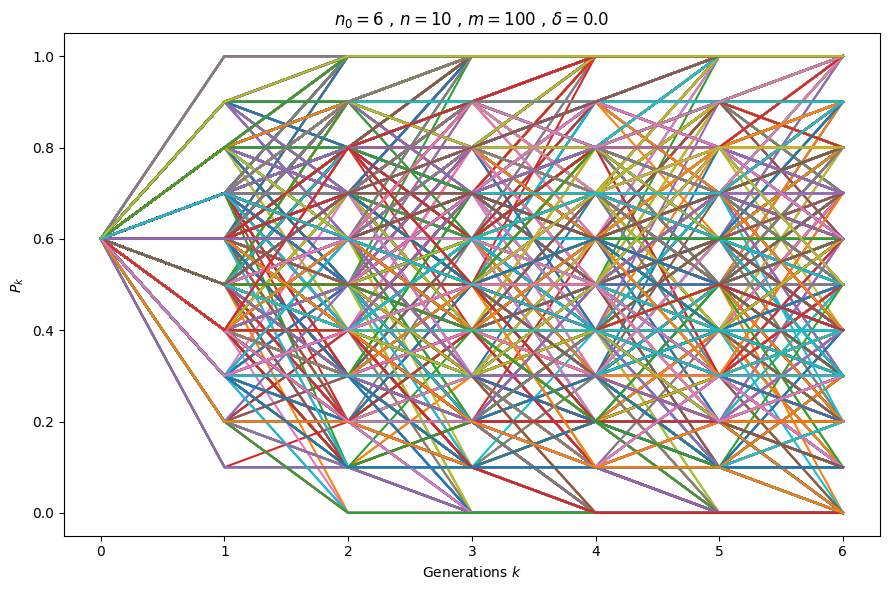

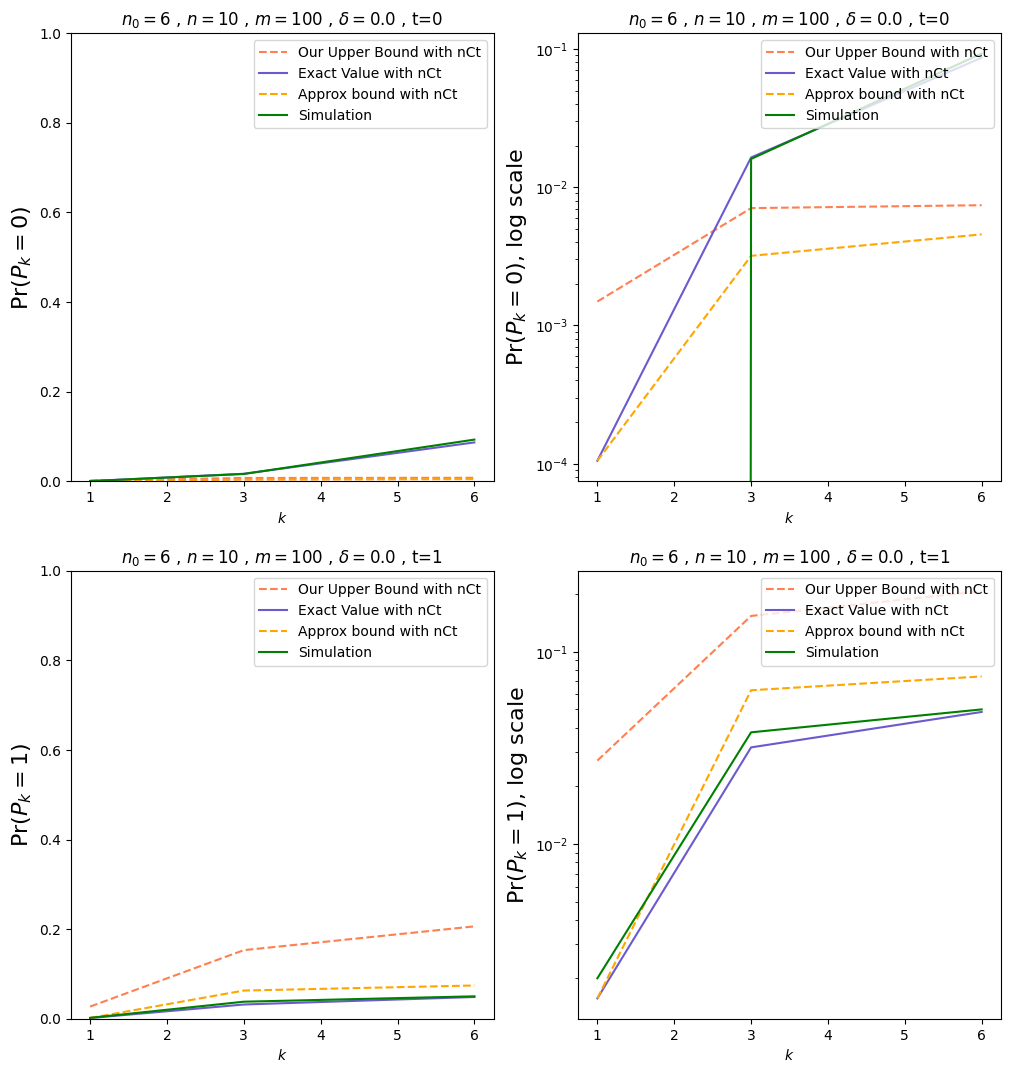

Using nCt : True


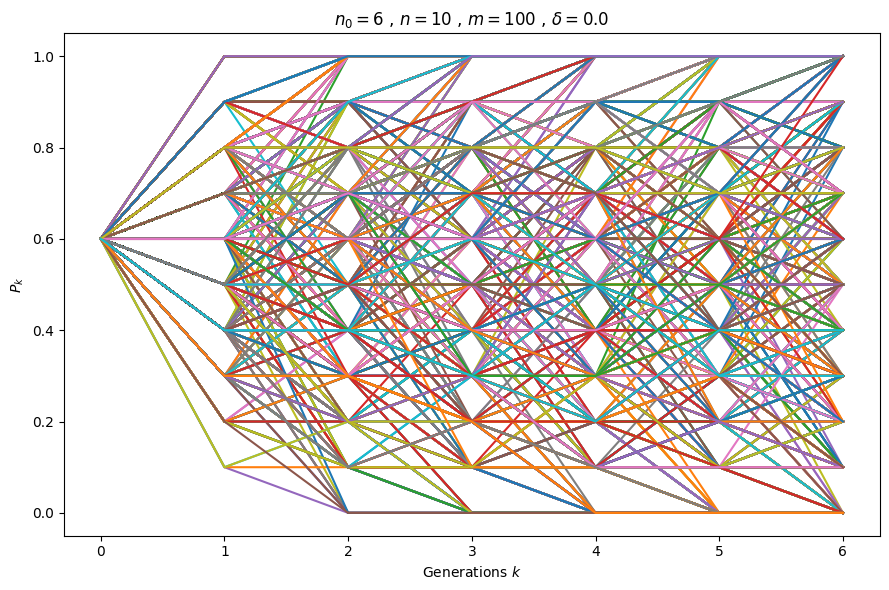

p0 0.6
Computed for t=1, k=3: Prob = 0.06288333574674354
p0 0.6
Computed for t=1, k=4: Prob = 0.0719673978328287
p0 0.6
Computed for t=1, k=5: Prob = 0.0750062964935174
p0 0.6
Computed for t=1, k=6: Prob = 0.07418634645637587
p0 0.6
Computed for t=1, k=4: Prob = 0.1139524820596752
p0 0.6
Computed for t=1, k=5: Prob = 0.11319940288236265
p0 0.6
Computed for t=1, k=6: Prob = 0.10926207775240827
p0 0.6
Computed for t=1, k=5: Prob = 0.15022591185985631
p0 0.6
Computed for t=1, k=6: Prob = 0.14427535171300698
p0 0.6
Computed for t=1, k=6: Prob = 0.17232257552249833
p0 0.6
Computed for t=0, k=1: Prob = 0.00010485760000000006
p0 0.6
Computed for t=0, k=2: Prob = 0.003890446869388289
p0 0.6
Computed for t=0, k=3: Prob = 0.016389677409212322
p0 0.6
Computed for t=0, k=4: Prob = 0.036338592587575436
p0 0.6
Computed for t=0, k=5: Prob = 0.06052755842544673
p0 0.6
Computed for t=0, k=6: Prob = 0.08640349203995001
p0 0.6
Computed for t=1, k=1: Prob = 0.0015728640000000006
p0 0.6
Computed for t=1, k

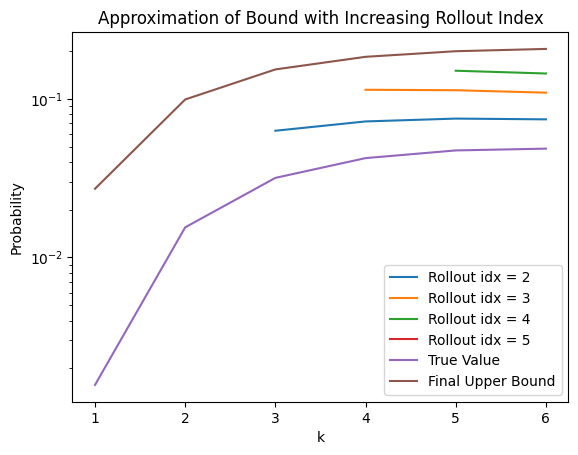

In [21]:
n_0_n_ng_m_delta_collapse_t_arr = [(6,10, 6, 100, 0.0, 1)]
with_nct = True

for n_0, n, ng, m, delta, collapse_t in n_0_n_ng_m_delta_collapse_t_arr:
    approx_bounds, approx_bounds_wo_nct = approx_bound_fn(n, m, delta, n_0, ng, collapse_t) # returns (collapse_t+1) * (ng) array
    true_probs, true_probs_wo_nct = true_bound_fn(n, m, delta, n_0, ng, collapse_t) # returns (collapse_t+1) * (ng) array
    trial((n_0, n, ng, m, delta), collapse_t, with_nct, approx_bounds, approx_bounds_wo_nct, true_probs, true_probs_wo_nct)


# plot progression of approx bound and true value on same plot as rollout_idx increases
for n_0, n, ng, m, delta, collapse_t in n_0_n_ng_m_delta_collapse_t_arr:
    collapse_array, our_upper =  plot_bernoulli_bounds(n_0,n, ng, m, delta, collapse_t, with_nct)
    plt.figure()
    for rollout_idx in range(2, 6):
        x_axis = list(range(rollout_idx + 1, ng+1))
        plt.plot(x_axis, approx_bound_fn_rollout_control(n, m, delta, n_0, ng, collapse_t, rollout_idx)[0], label=f'Rollout idx = {rollout_idx}')
    plt.plot(list(range(1, ng+1)), true_bound_fn(n, m, delta, n_0, ng, collapse_t)[0][collapse_t], label='True Value')
    plt.plot(list(range(1, ng+1)), np.array(our_upper)[collapse_t], label='Final Upper Bound')
    # plt.plot(list(range(1, ng+1)), np.array(collapse_array)[:, collapse_t], label='Simulation')
    # plt.ylim((0, 1))
    plt.yscale('log')
    plt.xlabel('k')
    plt.ylabel('Probability')
    plt.title('Approximation of Bound with Increasing Rollout Index')
    plt.legend()
    plt.savefig('bernoulli_rollout_idx.png')
    plt.savefig('bernoulli_rollout_idx.pdf')
    plt.show()
    plt.close()

1000
Using nCt : True


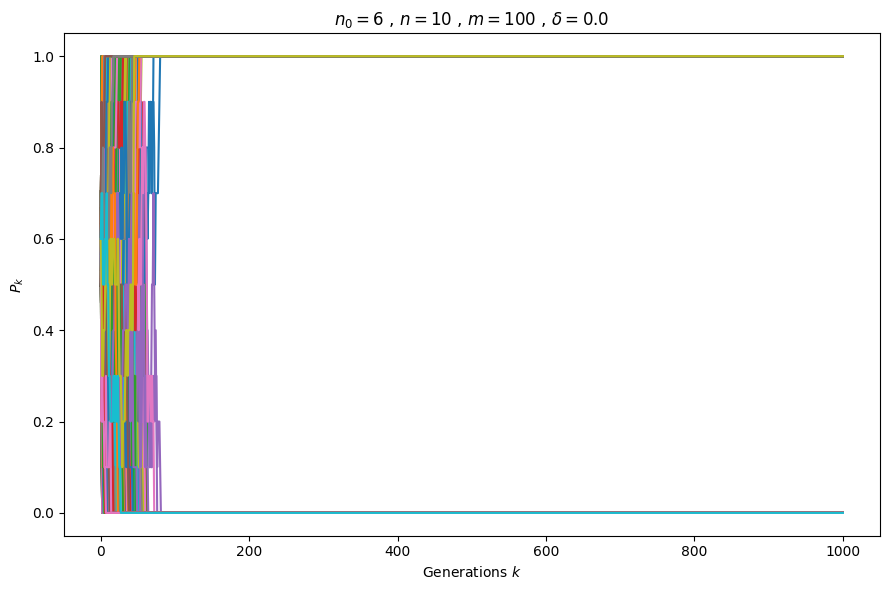

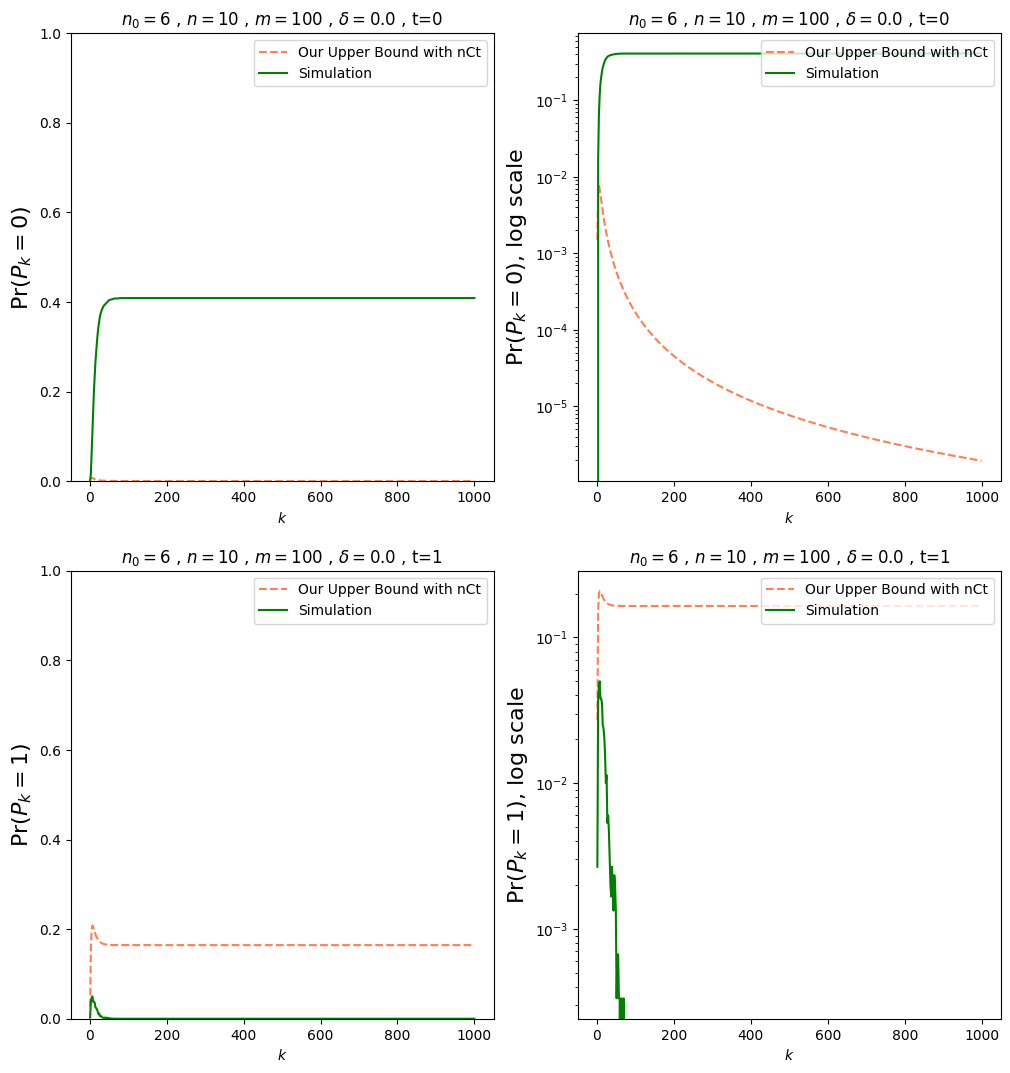

In [23]:
n_0_n_ng_m_delta_collapse_t_arr = [(6,10, 1000, 100, 0.0, 1)] 
# n_0_n_ng_m_delta_collapse_t_arr = [(400,1000, 10000, 1000, 0, 1), (500,1000, 4000, 1000, 0, 1)]
with_nct = True

for n_0, n, ng, m, delta, collapse_t in n_0_n_ng_m_delta_collapse_t_arr:
    # approx_bounds, approx_bounds_wo_nct = approx_bound_fn(n, m, delta, n_0, ng, collapse_t) # returns (collapse_t+1) * (ng) array
    # true_probs, true_probs_wo_nct = true_bound_fn(n, m, delta, n_0, ng, collapse_t) # returns (collapse_t+1) * (ng) array
    trial((n_0, n, ng, m, delta), collapse_t, with_nct)


# # plot progression of approx bound and true value on same plot as rollout_idx increases
# for n_0, n, ng, m, delta, collapse_t in n_0_n_ng_m_delta_collapse_t_arr:
#     collapse_array, our_upper =  plot_bernoulli_bounds(n_0,n, ng, m, delta, collapse_t, with_nct)
#     plt.figure()
#     for rollout_idx in range(2, 6):
#         x_axis = list(range(rollout_idx + 1, ng+1))
#         plt.plot(x_axis, approx_bound_fn_rollout_control(n, m, delta, n_0, ng, collapse_t, rollout_idx)[0], label=f'Rollout idx = {rollout_idx}')
#     plt.plot(list(range(1, ng+1)), true_bound_fn(n, m, delta, n_0, ng, collapse_t)[0][collapse_t], label='True Value')
#     plt.plot(list(range(1, ng+1)), np.array(our_upper)[collapse_t], label='Final Upper Bound')
#     # plt.plot(list(range(1, ng+1)), np.array(collapse_array)[:, collapse_t], label='Simulation')
#     # plt.ylim((0, 1))
#     plt.yscale('log')
#     plt.xlabel('k')
#     plt.ylabel('Probability')
#     plt.title('Approximation of Bound with Increasing Rollout Index')
#     plt.legend()
#     plt.savefig('bernoulli_rollout_idx.png')
#     plt.savefig('bernoulli_rollout_idx.pdf')
#     plt.show()
#     plt.close()

1000
Using nCt : True


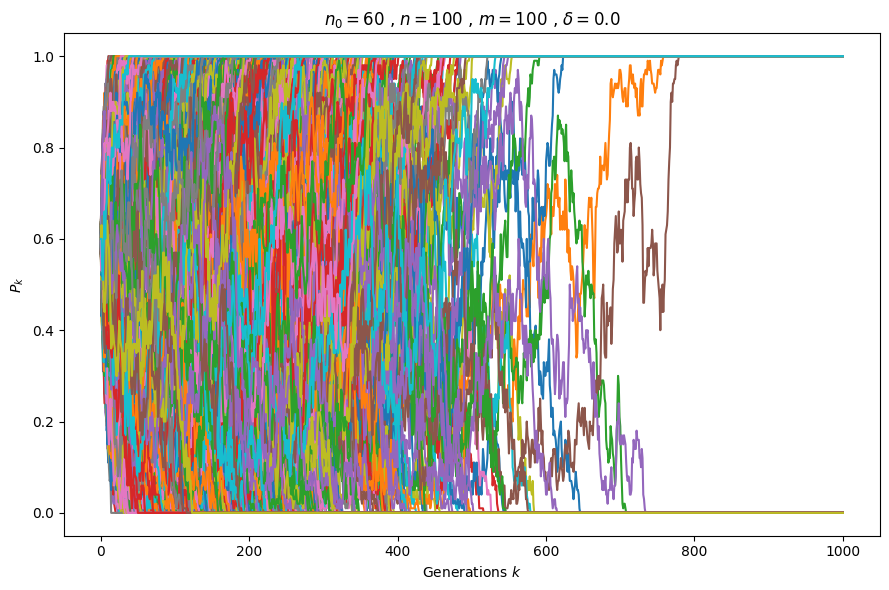

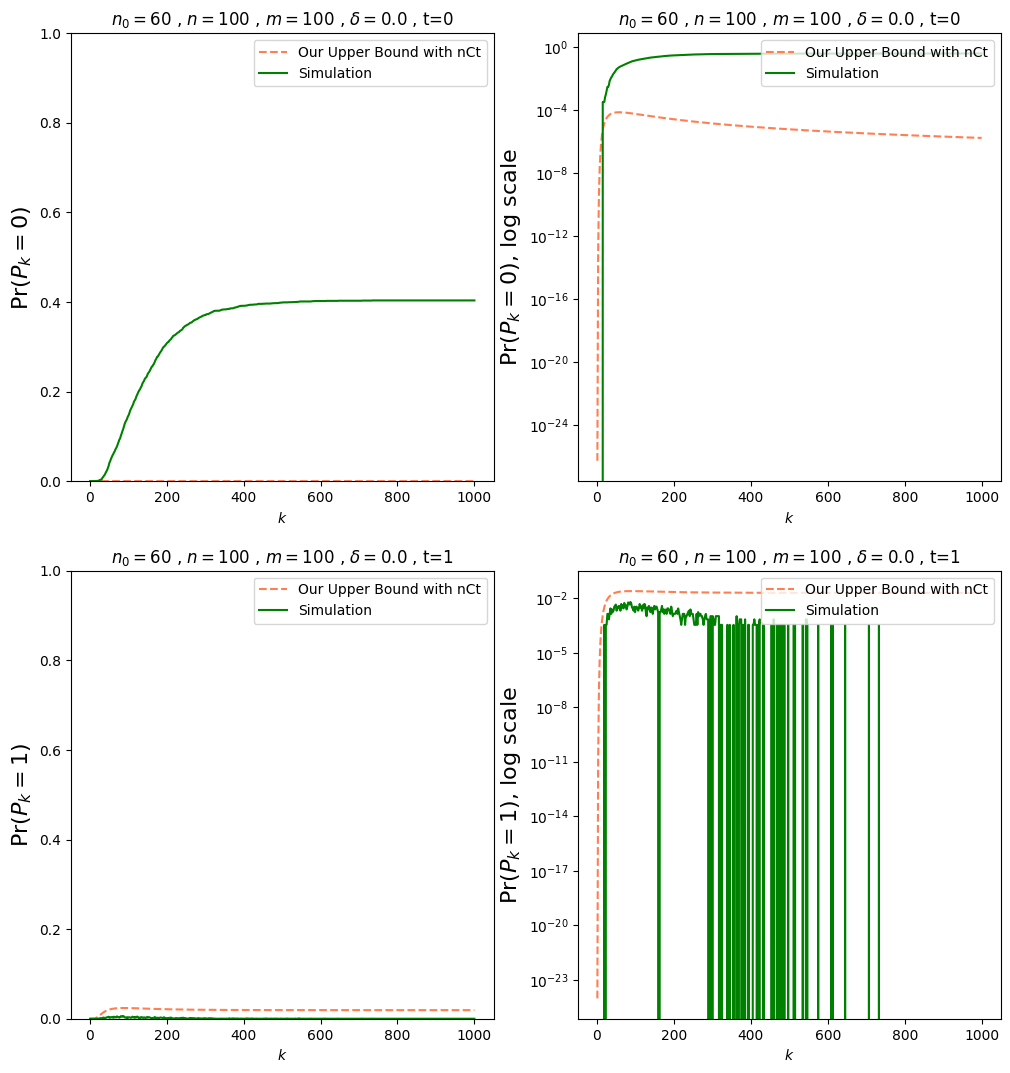

In [24]:
n_0_n_ng_m_delta_collapse_t_arr = [(60,100, 1000, 100, 0.0, 1)] 
# n_0_n_ng_m_delta_collapse_t_arr = [(400,1000, 10000, 1000, 0, 1), (500,1000, 4000, 1000, 0, 1)]
with_nct = True

for n_0, n, ng, m, delta, collapse_t in n_0_n_ng_m_delta_collapse_t_arr:
    # approx_bounds, approx_bounds_wo_nct = approx_bound_fn(n, m, delta, n_0, ng, collapse_t) # returns (collapse_t+1) * (ng) array
    # true_probs, true_probs_wo_nct = true_bound_fn(n, m, delta, n_0, ng, collapse_t) # returns (collapse_t+1) * (ng) array
    trial((n_0, n, ng, m, delta), collapse_t, with_nct)


# # plot progression of approx bound and true value on same plot as rollout_idx increases
# for n_0, n, ng, m, delta, collapse_t in n_0_n_ng_m_delta_collapse_t_arr:
#     collapse_array, our_upper =  plot_bernoulli_bounds(n_0,n, ng, m, delta, collapse_t, with_nct)
#     plt.figure()
#     for rollout_idx in range(2, 6):
#         x_axis = list(range(rollout_idx + 1, ng+1))
#         plt.plot(x_axis, approx_bound_fn_rollout_control(n, m, delta, n_0, ng, collapse_t, rollout_idx)[0], label=f'Rollout idx = {rollout_idx}')
#     plt.plot(list(range(1, ng+1)), true_bound_fn(n, m, delta, n_0, ng, collapse_t)[0][collapse_t], label='True Value')
#     plt.plot(list(range(1, ng+1)), np.array(our_upper)[collapse_t], label='Final Upper Bound')
#     # plt.plot(list(range(1, ng+1)), np.array(collapse_array)[:, collapse_t], label='Simulation')
#     # plt.ylim((0, 1))
#     plt.yscale('log')
#     plt.xlabel('k')
#     plt.ylabel('Probability')
#     plt.title('Approximation of Bound with Increasing Rollout Index')
#     plt.legend()
#     plt.savefig('bernoulli_rollout_idx.png')
#     plt.savefig('bernoulli_rollout_idx.pdf')
#     plt.show()
#     plt.close()

10000
Using nCt : True


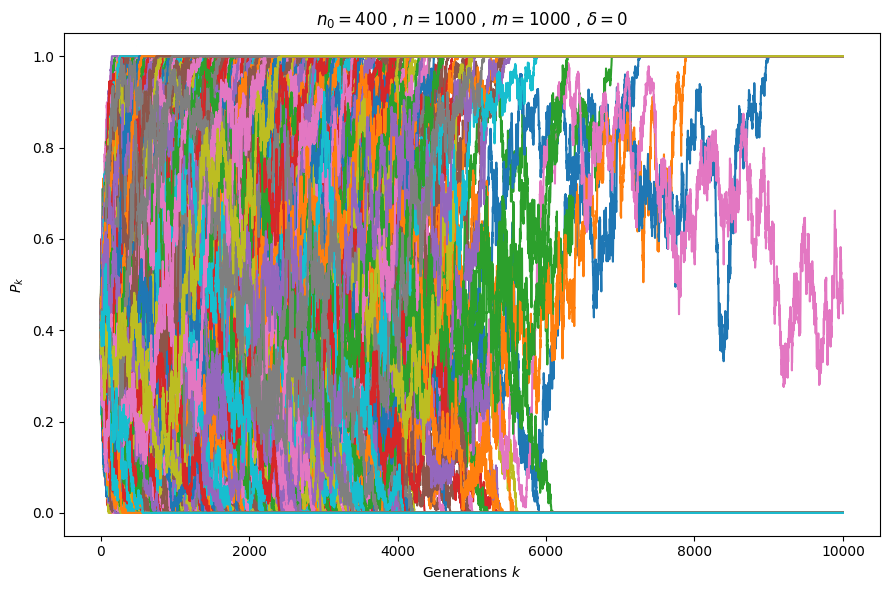

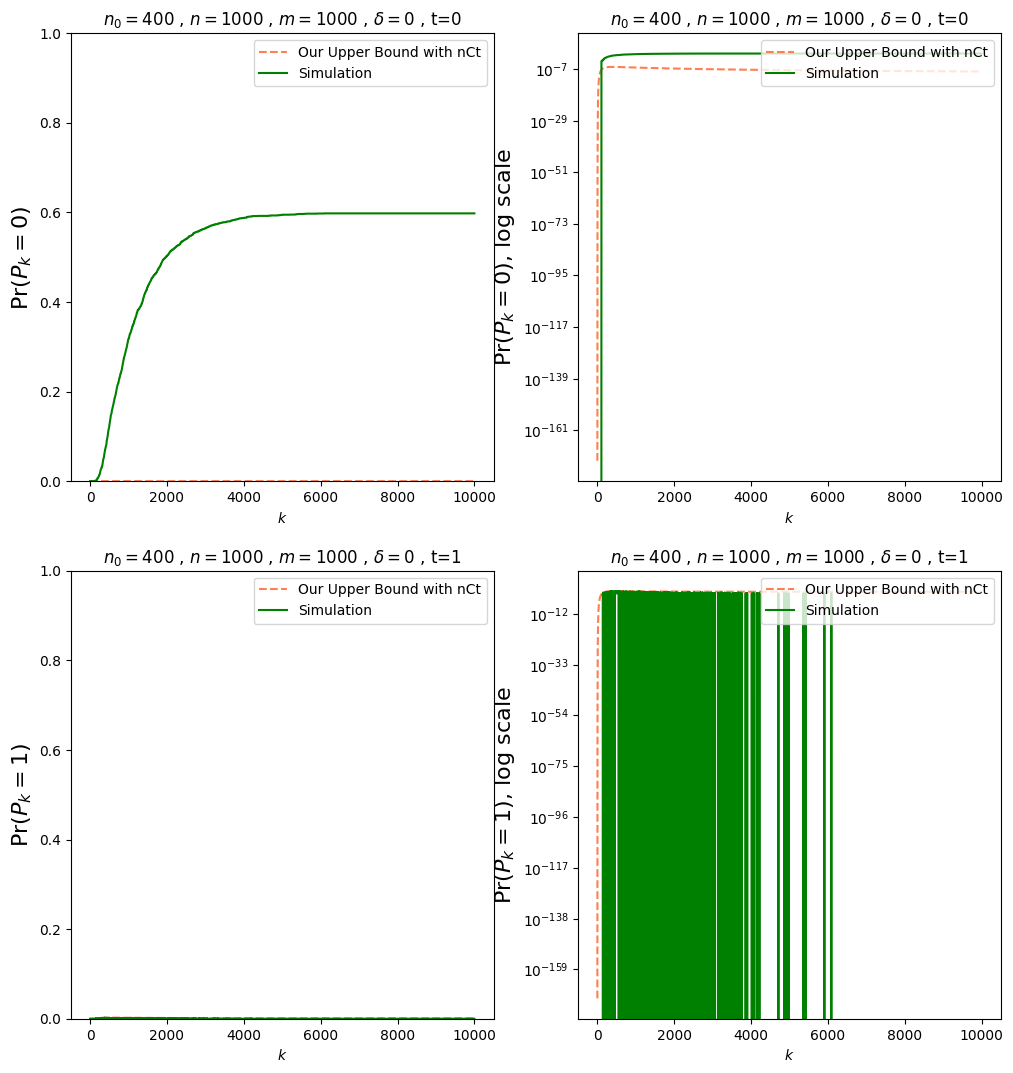

4000
Using nCt : True


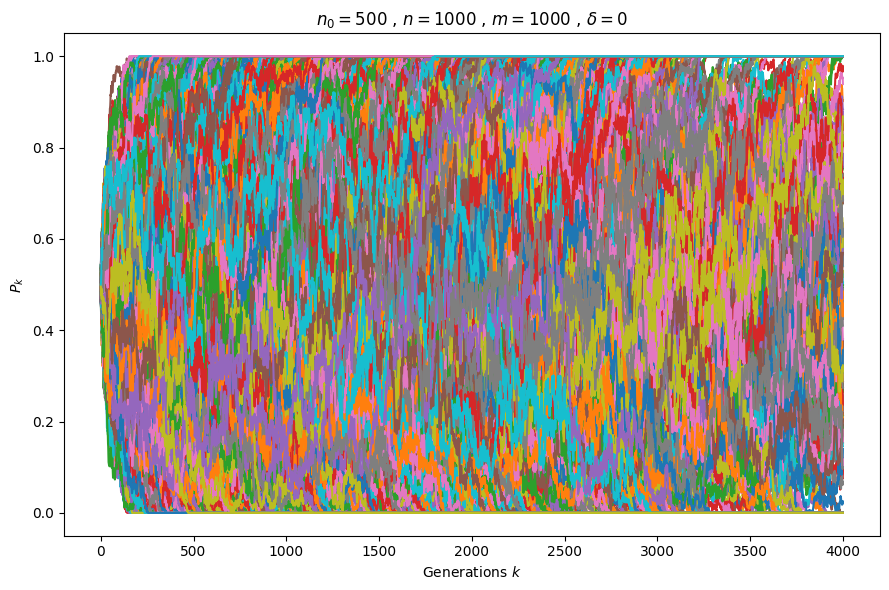

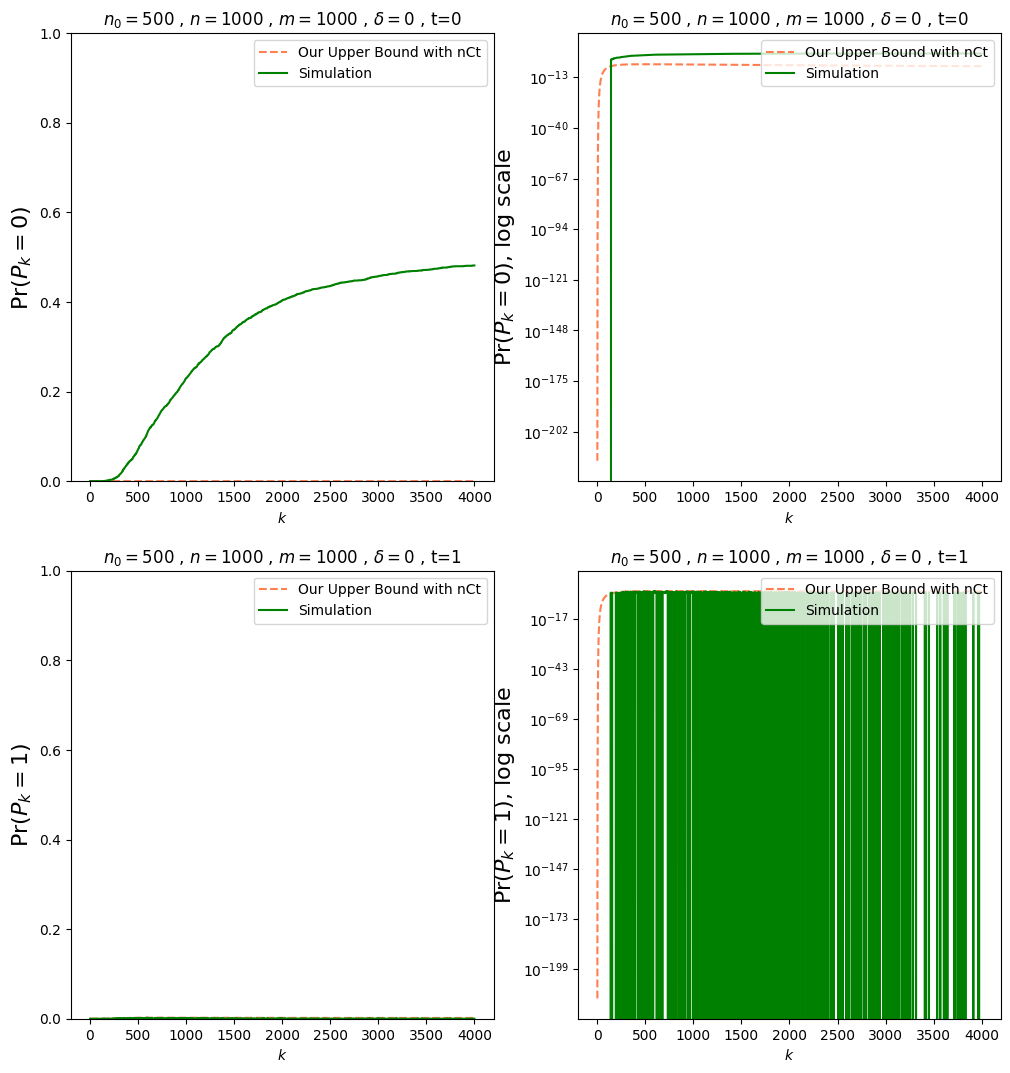

In [20]:
# n_0_n_ng_m_delta_collapse_t_arr = [(6,10, 6, 100, 0.0, 1)] 
n_0_n_ng_m_delta_collapse_t_arr = [(400,1000, 10000, 1000, 0, 1), (500,1000, 4000, 1000, 0, 1)]
with_nct = True

for n_0, n, ng, m, delta, collapse_t in n_0_n_ng_m_delta_collapse_t_arr:
    # approx_bounds, approx_bounds_wo_nct = approx_bound_fn(n, m, delta, n_0, ng, collapse_t) # returns (collapse_t+1) * (ng) array
    # true_probs, true_probs_wo_nct = true_bound_fn(n, m, delta, n_0, ng, collapse_t) # returns (collapse_t+1) * (ng) array
    trial((n_0, n, ng, m, delta), collapse_t, with_nct)


# # plot progression of approx bound and true value on same plot as rollout_idx increases
# for n_0, n, ng, m, delta, collapse_t in n_0_n_ng_m_delta_collapse_t_arr:
#     collapse_array, our_upper =  plot_bernoulli_bounds(n_0,n, ng, m, delta, collapse_t, with_nct)
#     plt.figure()
#     for rollout_idx in range(2, 6):
#         x_axis = list(range(rollout_idx + 1, ng+1))
#         plt.plot(x_axis, approx_bound_fn_rollout_control(n, m, delta, n_0, ng, collapse_t, rollout_idx)[0], label=f'Rollout idx = {rollout_idx}')
#     plt.plot(list(range(1, ng+1)), true_bound_fn(n, m, delta, n_0, ng, collapse_t)[0][collapse_t], label='True Value')
#     plt.plot(list(range(1, ng+1)), np.array(our_upper)[collapse_t], label='Final Upper Bound')
#     # plt.plot(list(range(1, ng+1)), np.array(collapse_array)[:, collapse_t], label='Simulation')
#     # plt.ylim((0, 1))
#     plt.yscale('log')
#     plt.xlabel('k')
#     plt.ylabel('Probability')
#     plt.title('Approximation of Bound with Increasing Rollout Index')
#     plt.legend()
#     plt.savefig('bernoulli_rollout_idx.png')
#     plt.savefig('bernoulli_rollout_idx.pdf')
#     plt.show()
#     plt.close()